In [1]:
import numpy as np
import pandas as pd
import progressbar
import os
from mat2py import mat2py

from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

%matplotlib inline

In [90]:
# This function imports processedtracks.mat files from a specified directory

def load_processed_condition(condition_dir, fields, tracking_file = 'ProcessedTracks.mat'):
    
    bar = progressbar.ProgressBar()
    
    files_to_load = []
    for root, subfolders, files in os.walk(condition_dir):
        if tracking_file in files:
            files_to_load.append([root, tracking_file])
    
    data_list = {}
    bar = progressbar.ProgressBar()
    for file in bar(files_to_load):
#         if os.path.isfile(os.path.join(file[0], "ProcessedTracks.npy")):
#             data = np.load(os.path.join(file[0], "ProcessedTracks.npy"))
#         else:
        file_to_open = os.path.join(file[0], file[1])
        data = mat2py(file_to_open, fields, file[0], 'tracks')
        
        data = pd.DataFrame(np.nan_to_num(np.array(data.tolist())),
                            columns = fields)
        data.index = np.arange(1, len(data)+1)
        data_list[file[0].split("/")[-3]] = data
        
    data = pd.concat(data_list.values(), keys=data_list.keys(), names=['cell', 'track'])
    return data.reset_index()

In [91]:
# The loading fields

fields = ['isPuff', 'hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 'tnpeaks', 'lifetime_s', 
          'percentC','MotionAnalysis', 'deltaf', 'SNR', 'tau', 'ttp', 'RSSm', 'global_background', 'plateau', 
          'int_density', 'nSeg', 'isPSFm', 'mask_Arm', 'maskNm', 'pval_Arm', 'maxAc']

In [36]:
# Load data

NW_5min = load_processed_condition('/Users/chenhao/Downloads/Fields/NW_Iso', fields)
NW_10min = load_processed_condition('/Users/chenhao/Downloads/Fields/NW_LatA', fields)
W_5min = load_processed_condition('/Users/chenhao/Downloads/Fields/W_Iso', fields)
W_10min = load_processed_condition('/Users/chenhao/Downloads/Fields/W_LatA', fields)

100% (15 of 15) |########################| Elapsed Time: 0:17:00 Time:  0:17:00
100% (15 of 15) |########################| Elapsed Time: 0:09:15 Time:  0:09:15
100% (28 of 28) |########################| Elapsed Time: 0:27:11 Time:  0:27:11
100% (28 of 28) |########################| Elapsed Time: 1:13:07 Time:  1:13:07


In [78]:
# Organize data in appropriate labels and save to .csv

new_data = pd.concat([NW_5min, NW_10min, W_5min, W_10min], keys=['NW_5min', 'NW_10min', 'W_5min', 'W_10min'], names=['condition'])
new_data = new_data.reset_index().drop('level_1',1)

for condition in ['NW_5min', 'NW_10min', 'W_5min', 'W_10min']:
    pieces = condition.split('_')
    treatment = pieces[0]
    timepoint = pieces[1]
    new_data.loc[new_data['condition'] == condition, 'treatment'] = treatment
    new_data.loc[new_data['condition'] == condition, 'timepoint'] = timepoint
    
new_data[['treatment', 'timepoint', 'cell', 'track'] + fields].to_csv('latB.csv')

In [2]:
data = pd.read_csv('latB.csv')
data = data.drop ('Unnamed: 0',1)

In [3]:
training_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 'tnpeaks', 'lifetime_s', 
          'percentC','MotionAnalysis', 'deltaf', 'SNR', 'tau', 'ttp', 'RSSm', 'global_background', 'plateau', 
          'int_density', 'nSeg', 'isPSFm', 'mask_Arm', 'maskNm', 'pval_Arm', 'maxAc']

In [4]:
# Train classifier

labeled = pd.read_csv('rr_sane.csv')
labeled = labeled.drop ('Unnamed: 0',1)

classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=1)

classifier.fit(labeled[training_fields], labeled['isPuff'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=True, random_state=237,
            verbose=0, warm_start=False)

In [40]:
# Use classifier to process organized tracks and output predictions

for treatment in np.unique(data['treatment']):
    for timepoint in np.unique(data.loc[data['treatment'] == treatment, 'timepoint']):
        for cell in np.unique(data.loc[(data['treatment'] == treatment) & (data['timepoint'] == timepoint), 'cell']):
            
            cell_filter = ((data['treatment'] == treatment) & (data['timepoint'] == timepoint) & (data['cell'] == cell))
            
            test_probas = classifier.predict_proba(data.loc[(data['treatment'] == treatment) 
                                                & (data['timepoint'] == timepoint) 
                                                & (data['cell'] == cell), training_fields])[:,0]
            
            logic_arr = np.array(test_probas >= 0.9)
            data.loc[cell_filter, 'logic'] = logic_arr        
            ispuff_arr = np.nonzero(logic_arr)            
            data.loc[cell_filter, 'proba'] = test_probas
            
#            print (len(np.array(ispuff_arr)[0]))
#            if len(np.array(ispuff_arr)[0]) > 0:
#                print (treatment, timepoint, cell, ispuff_arr)
#            if len(np.array(ispuff_arr)[0]) == 0:
#                print (treatment, timepoint, cell, '0')

In [41]:
#data

In [42]:
thresholded = data.groupby(['treatment', 'cell', 'timepoint'])['logic'].sum()
thresholded.to_csv('thresholded_0.9.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


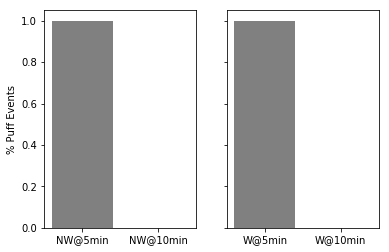

In [8]:
import seaborn as sns

ispuff_count_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint','cell'])['logic'].sum() / 
                              data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :].groupby(['cell'])['logic'].sum()).reset_index()
ispuff_count_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint','cell'])['logic'].sum() / 
                              data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :].groupby(['cell'])['logic'].sum()).reset_index()

fig, axs = plt.subplots(1,2, sharey=True)
sns.set_palette(['grey', sns.xkcd_rgb['sky blue']])
sns.barplot(data = ispuff_count_NW, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% Puff Events')
axs[0].set_xticklabels(['NW@5min', 'NW@10min'])
axs[0].set_xlabel('')

sns.barplot(data = ispuff_count_W, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['W@5min', 'W@10min'])
axs[1].set_xlabel('')
plt.show()

In [8]:
data.groupby(['treatment', 'cell', 'timepoint'])['proba'].sum()

treatment  cell            timepoint
NW         Field1.2_0.1s   5min          32.5225
           Field1.4_0.1s   10min         42.8135
           Field10.2_0.1s  5min           7.6460
           Field10.4_0.1s  10min          2.5985
           Field11.2_0.1s  5min          24.6670
           Field11.4_0.1s  10min          3.2600
           Field12.2_0.1s  5min          38.2640
           Field12.4_0.1s  10min          6.7320
           Field13.2_0.1s  5min          16.9195
           Field13.4_0.1s  10min         10.7625
           Field14.2_0.1s  5min           4.3245
           Field14.4_0.1s  10min          4.7655
           Field15.2_0.1s  5min           8.7550
           Field15.4_0.1s  10min          3.0680
           Field2.2_0.1s   5min          26.9025
           Field2.4_0.1s   10min          8.4855
           Field3.2_0.1s   5min          15.5485
           Field3.4_0.1s   10min         12.3325
           Field4.2_0.1s   5min          21.5070
           Field4.4_0.1s   10min

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


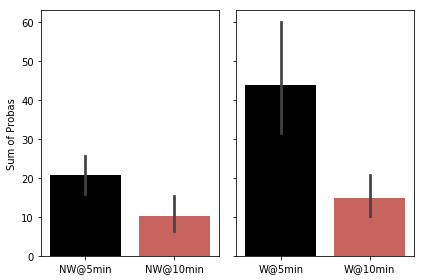

In [9]:
sum_probas_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint', 'cell'])['proba'].sum()).reset_index()
sum_probas_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint', 'cell'])['proba'].sum()).reset_index()

fig, axs = plt.subplots(1,2, sharey=True)
sns.set_palette(['black', sns.xkcd_rgb['pale red']])
sns.barplot(data = sum_probas_NW, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('Sum of Probas')
axs[0].set_xticklabels(['NW@5min', 'NW@10min'])
axs[0].set_xlabel('')

sns.barplot(data = sum_probas_W, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['W@5min', 'W@10min'])
axs[1].set_xlabel('')
#ax.text(0.4, -200, 'NW')
#ax.text(2.4, -200, 'W')
#line = plt.Line2D([0.5, 0.5], [-0.005, -0.15], color='black', transform=ax.transAxes)
#line.set_clip_on(False)
#ax.add_line(line)
plt.tight_layout()
plt.show()

In [10]:
# Re-train classifier with MOR data only

labeled_M = labeled.loc[labeled['cargo'] == 'MOR', :]

classifier_M = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=1)

classifier_M.fit(labeled_M[training_fields], labeled_M['isPuff'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=True, random_state=237,
            verbose=0, warm_start=False)

In [47]:
# Set up calibration for the MOR trained data

calibrater = LogisticRegression(C = 1000000, random_state=237, solver = 'lbfgs')
train_puff_probs = classifier_M.oob_decision_function_[:,0]
train_puff_labeled = labeled_M['isPuff']
calibrater.fit(train_puff_probs.reshape(-1, 1), train_puff_labeled)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=237,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Organize the new predictions and save to the dataset

for treatment in np.unique(data['treatment']):
    for timepoint in np.unique(data.loc[data['treatment'] == treatment, 'timepoint']):
        for cell in np.unique(data.loc[(data['treatment'] == treatment) & (data['timepoint'] == timepoint), 'cell']):
            
            cell_filter = ((data['treatment'] == treatment) & (data['timepoint'] == timepoint) & (data['cell'] == cell))
            
            test_probas_M = classifier_M.predict_proba(data.loc[(data['treatment'] == treatment) 
                                                & (data['timepoint'] == timepoint) 
                                                & (data['cell'] == cell), training_fields])[:,0]
            calibrated_probas_M = calibrater.predict_proba(test_probas_M.reshape(-1, 1))[:,0]
            logic_arr_M = np.array(test_probas_M >= 0.5)
            logic_arr_calibrated = np.array(calibrated_probas_M >= 0.5)

            data.loc[cell_filter, 'proba_M'] = test_probas_M
            data.loc[cell_filter, 'logic_M'] = logic_arr_M
            data.loc[cell_filter, 'calibrated_M'] = calibrated_probas_M
            data.loc[cell_filter, 'logic_calibrated'] = logic_arr_calibrated

In [46]:
data.groupby(['treatment', 'cell', 'timepoint'])['calibrated_M'].sum()

treatment  cell            timepoint
NW         Field1.2_0.1s   5min         29.624550
           Field1.4_0.1s   10min        35.079573
           Field10.2_0.1s  5min          4.383887
           Field10.4_0.1s  10min         3.007056
           Field11.2_0.1s  5min          8.550029
           Field11.4_0.1s  10min         4.543874
           Field12.2_0.1s  5min         21.402891
           Field12.4_0.1s  10min        13.237502
           Field13.2_0.1s  5min          9.396102
           Field13.4_0.1s  10min         8.063756
           Field14.2_0.1s  5min          2.151579
           Field14.4_0.1s  10min         4.490285
           Field15.2_0.1s  5min          7.456202
           Field15.4_0.1s  10min         4.450252
           Field2.2_0.1s   5min         17.820188
           Field2.4_0.1s   10min         7.289464
           Field3.2_0.1s   5min         15.069568
           Field3.4_0.1s   10min        12.988776
           Field4.2_0.1s   5min         10.792016
           Fi

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


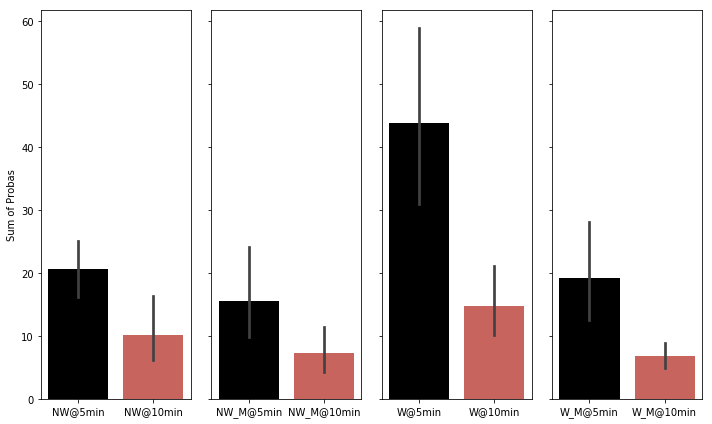

In [12]:
# "Sum of probas" of each treatment and timepoint, both classifiers. Non-normalized.

sum_NW_M = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint', 'cell'])['proba_M'].sum()).reset_index()
sum_W_M = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint', 'cell'])['proba_M'].sum()).reset_index()

fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['black', sns.xkcd_rgb['pale red']])

sns.barplot(data = sum_probas_NW, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('Sum of Probas')
axs[0].set_xticklabels(['NW@5min', 'NW@10min'])
axs[0].set_xlabel('')

sns.barplot(data = sum_NW_M, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_M@5min', 'NW_M@10min'])
axs[1].set_xlabel('')

sns.barplot(data = sum_probas_W, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W@5min', 'W@10min'])
axs[2].set_xlabel('')

sns.barplot(data = sum_W_M, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_M@5min', 'W_M@10min'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

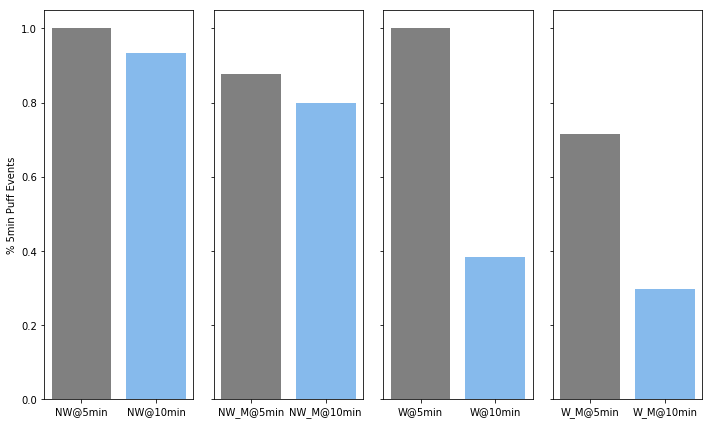

In [13]:
# Normalization of "ispuff count" data generated by threshold method to 5min timepoint, both classifiers.

ispuff_NW_M = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['logic_M'].sum() / 
                              data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['logic'].sum()).reset_index()
ispuff_W_M = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['logic_M'].sum() / 
                              data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['logic'].sum()).reset_index()

fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['grey', sns.xkcd_rgb['sky blue']])

sns.barplot(data = ispuff_count_NW, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min Puff Events')
axs[0].set_xticklabels(['NW@5min', 'NW@10min'])
axs[0].set_xlabel('')

sns.barplot(data = ispuff_NW_M, 
                 x = 'timepoint', 
                 y = 'logic_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_M@5min', 'NW_M@10min'])
axs[1].set_xlabel('')

sns.barplot(data = ispuff_count_W, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W@5min', 'W@10min'])
axs[2].set_xlabel('')

sns.barplot(data = ispuff_W_M, 
                 x = 'timepoint', 
                 y = 'logic_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_M@5min', 'W_M@10min'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

In [14]:
# Normalization of "proba sum" data to each treatment's 5min timepoint.

nor_sum_probas_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['proba'].sum() / 
                                 data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()
nor_sum_probas_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['proba'].sum() / 
                                data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()
nor_sum_NW_M = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['proba_M'].sum() / 
                            data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()
nor_sum_W_M = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['proba_M'].sum() / 
                           data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()

In [15]:
a = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint', 'cell'])['proba'].sum() / 
                                 data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :].groupby(['cell'])['proba'].sum()).reset_index()
a

,timepoint,cell,proba
0,10min,Field1.4_0.1s,NaN
1,10min,Field10.4_0.1s,NaN
2,10min,Field11.4_0.1s,NaN
3,10min,Field12.4_0.1s,NaN
4,10min,Field13.4_0.1s,NaN
5,10min,Field14.4_0.1s,NaN
6,10min,Field15.4_0.1s,NaN
7,10min,Field2.4_0.1s,NaN
8,10min,Field3.4_0.1s,NaN
9,10min,Field4.4_0.1s,NaN


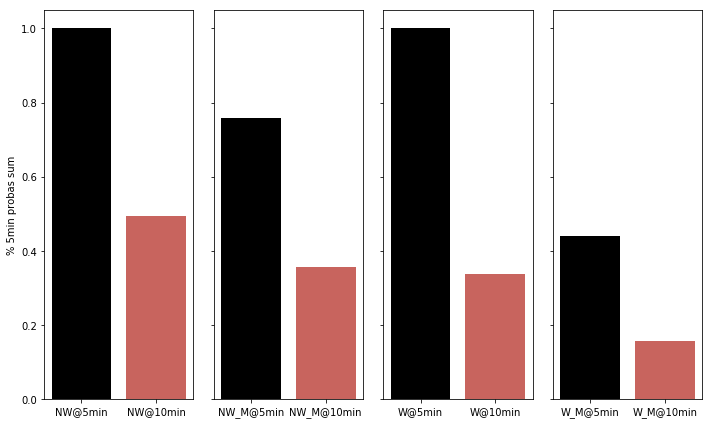

In [16]:
fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['black', sns.xkcd_rgb['pale red']])

sns.barplot(data = nor_sum_probas_NW, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min probas sum')
axs[0].set_xticklabels(['NW@5min', 'NW@10min'])
axs[0].set_xlabel('')

sns.barplot(data = nor_sum_NW_M, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_M@5min', 'NW_M@10min'])
axs[1].set_xlabel('')

sns.barplot(data = nor_sum_probas_W, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W@5min', 'W@10min'])
axs[2].set_xlabel('')

sns.barplot(data = nor_sum_W_M, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_M@5min', 'W_M@10min'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

In [18]:
# Normalization of "proba sum" data to each treatment's 5min timepoint generated from Prism

pan_classifier = data.groupby(['treatment', 'timepoint', 'cell'])['proba'].sum()
specific_classifier = data.groupby(['treatment', 'timepoint', 'cell'])['proba_M'].sum()

pd.concat([pan_classifier, specific_classifier]).to_csv('proba_sum.csv')

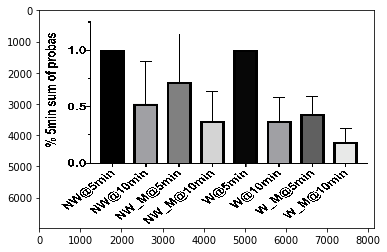

In [19]:
img = plt.imread('/Users/chenhao/Downloads/puffsAnalysis-master/My_own_data/probas_sum_data.png')
plt.imshow(img, aspect='auto')
plt.show()

In [58]:
# Comparsion of calibrated predictions with initial predictions

ispuff_toM_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['logic_M'].sum() / 
                              data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['logic_M'].sum()).reset_index()
ispuff_toM_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['logic_M'].sum() / 
                              data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['logic_M'].sum()).reset_index()
sum_norto_M_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['proba_M'].sum() / 
                            data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['proba_M'].sum()).reset_index()
sum_norto_M_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['proba_M'].sum() / 
                           data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['proba_M'].sum()).reset_index()

a = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['logic_calibrated'].sum() / 
                              data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['logic_M'].sum()).reset_index()
b = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['logic_calibrated'].sum() / 
                              data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['logic_M'].sum()).reset_index()
c = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['calibrated_M'].sum() / 
                            data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['proba_M'].sum()).reset_index()
d = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['calibrated_M'].sum() / 
                           data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['proba_M'].sum()).reset_index()

ispuff_NW_calibrated = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['logic_calibrated'].sum() / 
                              data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['logic'].sum()).reset_index()
ispuff_W_calibrated = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['logic_calibrated'].sum() / 
                              data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['logic'].sum()).reset_index()
calibrated_sum_NW = pd.DataFrame(data.loc[data['treatment'] == 'NW', :].groupby(['timepoint'])['calibrated_M'].sum() / 
                            data.loc[(data['treatment'] == 'NW') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()
calibrated_sum_W = pd.DataFrame(data.loc[data['treatment'] == 'W', :].groupby(['timepoint'])['calibrated_M'].sum() / 
                           data.loc[(data['treatment'] == 'W') & (data['timepoint'] == '5min'), :]['proba'].sum()).reset_index()

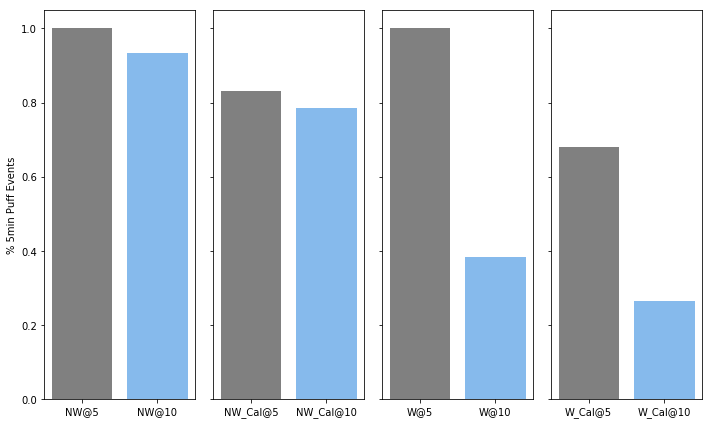

In [55]:
fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['grey', sns.xkcd_rgb['sky blue']])

sns.barplot(data = ispuff_count_NW, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min Puff Events')
axs[0].set_xticklabels(['NW@5', 'NW@10'])
axs[0].set_xlabel('')

sns.barplot(data = ispuff_NW_calibrated, 
                 x = 'timepoint', 
                 y = 'logic_calibrated',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_Cal@5', 'NW_Cal@10'])
axs[1].set_xlabel('')

sns.barplot(data = ispuff_count_W, 
                 x = 'timepoint', 
                 y = 'logic',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W@5', 'W@10'])
axs[2].set_xlabel('')

sns.barplot(data = ispuff_W_calibrated, 
                 x = 'timepoint', 
                 y = 'logic_calibrated',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_Cal@5', 'W_Cal@10'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

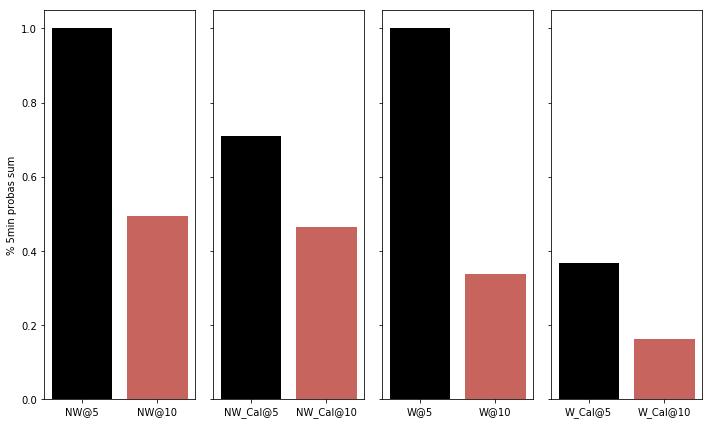

In [57]:
fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['black', sns.xkcd_rgb['pale red']])

sns.barplot(data = nor_sum_probas_NW, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min probas sum')
axs[0].set_xticklabels(['NW@5', 'NW@10'])
axs[0].set_xlabel('')

sns.barplot(data = calibrated_sum_NW, 
                 x = 'timepoint', 
                 y = 'calibrated_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_Cal@5', 'NW_Cal@10'])
axs[1].set_xlabel('')

sns.barplot(data = nor_sum_probas_W, 
                 x = 'timepoint', 
                 y = 'proba',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W@5', 'W@10'])
axs[2].set_xlabel('')

sns.barplot(data = calibrated_sum_W, 
                 x = 'timepoint', 
                 y = 'calibrated_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_Cal@5', 'W_Cal@10'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

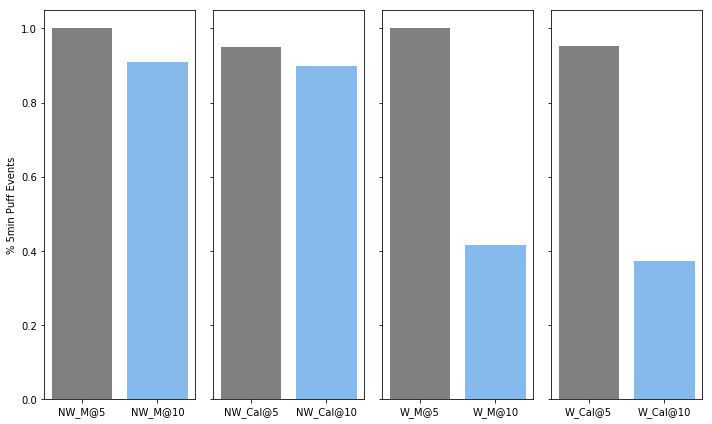

In [59]:
fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['grey', sns.xkcd_rgb['sky blue']])

sns.barplot(data = ispuff_toM_NW, 
                 x = 'timepoint', 
                 y = 'logic_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min Puff Events')
axs[0].set_xticklabels(['NW_M@5', 'NW_M@10'])
axs[0].set_xlabel('')

sns.barplot(data = a, 
                 x = 'timepoint', 
                 y = 'logic_calibrated',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_Cal@5', 'NW_Cal@10'])
axs[1].set_xlabel('')

sns.barplot(data = ispuff_toM_W, 
                 x = 'timepoint', 
                 y = 'logic_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W_M@5', 'W_M@10'])
axs[2].set_xlabel('')

sns.barplot(data = b, 
                 x = 'timepoint', 
                 y = 'logic_calibrated',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_Cal@5', 'W_Cal@10'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

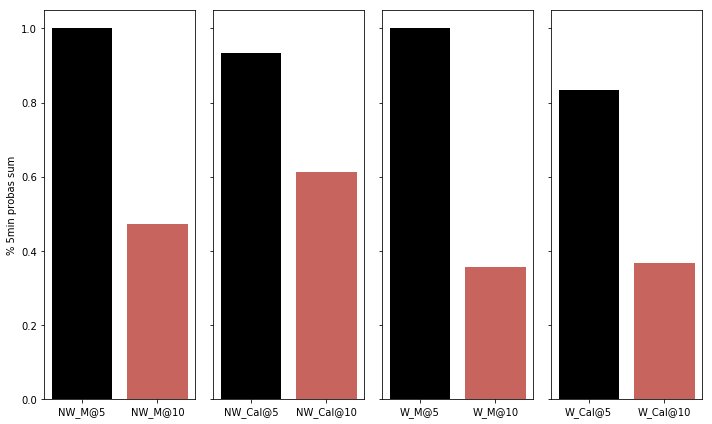

In [60]:
fig, axs = plt.subplots(1,4, sharey=True)
sns.set_palette(['black', sns.xkcd_rgb['pale red']])

sns.barplot(data = sum_norto_M_NW, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[0])
axs[0].set_ylabel('% 5min probas sum')
axs[0].set_xticklabels(['NW_M@5', 'NW_M@10'])
axs[0].set_xlabel('')

sns.barplot(data = c, 
                 x = 'timepoint', 
                 y = 'calibrated_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xticklabels(['NW_Cal@5', 'NW_Cal@10'])
axs[1].set_xlabel('')

sns.barplot(data = sum_norto_M_W, 
                 x = 'timepoint', 
                 y = 'proba_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xticklabels(['W_M@5', 'W_M@10'])
axs[2].set_xlabel('')

sns.barplot(data = d, 
                 x = 'timepoint', 
                 y = 'calibrated_M',
                 ci = 95,
                 order = ['5min', '10min'],
                 ax= axs[3])
axs[3].set_ylabel('')
axs[3].set_xticklabels(['W_Cal@5', 'W_Cal@10'])
axs[3].set_xlabel('')

fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()